In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from tqdm import tqdm

%matplotlib inline

In [2]:
class LUT:
    def __init__(self, inputs, indexes_0, indexes_1, k , index = []):
        # build lut
        self.k = k
        if (index == []):
            self.index = np.sort(np.random.choice(len(inputs[0]),k,replace = False))
        else:
            self.index = index
        self.inv = np.arange(k-1,-1,-1)
        self.output = np.zeros((2**k), int)
        self.count_0 = np.zeros((2**k), int)
        self.count_1 = np.zeros((2**k), int)
        self.count(inputs[:,self.index], indexes_0,indexes_1)
        
    def count(self, subset, indexes_0, indexes_1):
        zeros = Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_0])))
        ones =  Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_1])))
        for key in zeros.keys():
            self.count_0[key] = zeros[key]
        for key in ones.keys():
            self.count_1[key] = ones[key]
        # compute lut
        self.output[self.count_0 > self.count_1] = 0
        self.output[self.count_0 < self.count_1] = 1
        # picked uniformly at random
        self.output[self.count_0 == self.count_1] = np.random.choice([0,1], len(self.output[self.count_0 == self.count_1]))
        
    def get_index_vec_to_dec(self, X , axis = 1):
        dec_index = np.sum(X * np.power(2*np.ones(self.k,int),self.inv),axis= axis)
        return dec_index
    
    def get_index_dec_to_vec(self, dec):
        return "{0:b}".format(dec).zfill(self.k)
    
    def look(self, X):
        # X is a numpy array
        X = np.array(X)
        return self.output[self.get_index_vec_to_dec(X[self.index], 0)]
    
    def look_array(self, dataset):
        subdataset = dataset[:,self.index]
        return self.output[self.get_index_vec_to_dec(subdataset)]
        
    def score(self, labels, dataset):
        predicted = self.look_array(dataset)
        return accuracy_score(labels,predicted)
    
    def show(self):
        print("Look up table")
        print("Index = {}".format(self.index))
        print("  p    |  y0 |  y1 |  f   |")
        for i in range(len(self.output)):
            if (self.count_0[i] == self.count_1[i]):
                f = "{}*".format(self.output[i])
            else:
                f = "{} ".format(self.output[i])
            print("  {}   |  {}  |  {}  |  {}  |".format(self.get_index_dec_to_vec(i), self.count_0[i], self.count_1[i], f))
            
    def clean(self):
        self.count_0 = None
        self.count_1 = None

In [29]:
class NLUTS :
    def __init__(self,k,n_luts = [1024,512,512,256,16,1], n_layer = 6):
        self.layers = []
        self.k = k
        self.n_layer = n_layer
        self.n_luts = n_luts
    
    def train(self,X_train,y_train, indexes_0, indexes_1):

        inputs = X_train
        outputs = inputs
        # hidden layers + 1 output layer
        for l in range(self.n_layer):
            layer = []
            inputs = outputs
            outputs = np.zeros((len(X_train),self.n_luts[l]),int)
            for i in range(n_luts[l]):
                lut = LUT(inputs, indexes_0, indexes_1, self.k)
                outputs[:,i] = lut.look_array(inputs)
                layer.append(lut)
            self.layers.append(layer)
        return outputs
    
    def predict(self,X,y):
        inputs = X
        outputs = inputs
        for layer in self.layers:
            inputs = outputs
            outputs = np.zeros((len(X),len(layer)),int)
            for i in range(len(layer)):
                outputs[:,i] = layer[i].look_array(inputs)
        return outputs
    
    def score(self,X,y):
        return accuracy_score(y, self.predict(X,y))

In [8]:
with open('./data/mnist/mnist_X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/mnist/binarized_mnist_y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/mnist/mnist_X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/mnist/binarized_mnist_y_test.p', 'rb') as f:
    y_test = pickle.load(f)

## Test varying the number of luts

In [4]:
n_luts = [784,64,64,64,64,8,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

layer 0 nb luts : 784


100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [00:12<00:00, 61.61it/s]


layer 1 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 13.24it/s]


layer 2 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 10.45it/s]


layer 3 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:05<00:00, 11.76it/s]


layer 4 nb luts : 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 13.54it/s]


layer 5 nb luts : 8


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.12it/s]


layer 6 nb luts : 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.79it/s]


Time spent : 34.74s
Experiment 1 bis : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,8.000000,1.00000
mean,0.507220,0.615896,0.752570,0.823302,0.849653,0.862085,0.86985
std,0.036831,0.044488,0.021528,0.006580,0.002479,0.000937,NaN
min,0.402167,0.517467,0.695167,0.805350,0.842200,0.860633,0.86985
25%,0.495071,0.582087,0.736204,0.819758,0.848258,0.861617,0.86985
50%,0.509933,0.607817,0.755658,0.823675,0.849992,0.861950,0.86985
75%,0.513792,0.640533,0.769258,0.827817,0.851162,0.862625,0.86985
max,0.668500,0.714183,0.787350,0.836833,0.854683,0.863417,0.86985


In [5]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.51it/s]


Time spent : 3.86s
Experiment 1bis : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,64.000000,64.000000,64.000000,64.000000,8.000000,1.0000
mean,0.511235,0.621620,0.758478,0.825833,0.847450,0.854600,0.8549
std,0.038818,0.049406,0.024504,0.007608,0.003467,0.001752,NaN
min,0.391300,0.519100,0.690900,0.801700,0.838000,0.851400,0.8549
25%,0.497475,0.586900,0.740325,0.822025,0.845000,0.853650,0.8549
50%,0.513900,0.614500,0.759900,0.826100,0.847800,0.855050,0.8549
75%,0.517125,0.658200,0.777125,0.831800,0.849500,0.856050,0.8549
max,0.684600,0.725900,0.799300,0.839500,0.857300,0.856300,0.8549


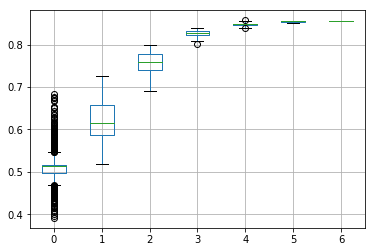

In [6]:
df.boxplot()

In [ ]:
n_luts = [784,64,64,64,64,8,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1 bis : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

In [ ]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

print("Experiment 1bis : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

In [25]:
n_luts = [1024,512,512,256,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.702
k = 2 test accuracy : 0.715
Time spent :193.80s
k = 4 training accuracy : 0.816
k = 4 test accuracy : 0.819
Time spent :217.41s
k = 6 training accuracy : 0.856
k = 6 test accuracy : 0.854
Time spent :255.88s
k = 8 training accuracy : 0.904
k = 8 test accuracy : 0.882
Time spent :295.56s
k = 10 training accuracy : 0.957
k = 10 test accuracy : 0.902
Time spent :338.51s
k = 12 training accuracy : 0.990
k = 12 test accuracy : 0.902
Time spent :387.90s
k = 14 training accuracy : 0.999
k = 14 test accuracy : 0.822
Time spent :437.24s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.659
Time spent :505.93s
Total Time spent : 2633.20s


In [26]:
n_luts = [512,256,256,64,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.706
k = 2 test accuracy : 0.719
Time spent :100.00s
k = 4 training accuracy : 0.818
k = 4 test accuracy : 0.827
Time spent :115.21s
k = 6 training accuracy : 0.866
k = 6 test accuracy : 0.862
Time spent :138.67s
k = 8 training accuracy : 0.905
k = 8 test accuracy : 0.884
Time spent :154.91s
k = 10 training accuracy : 0.953
k = 10 test accuracy : 0.899
Time spent :183.67s
k = 12 training accuracy : 0.991
k = 12 test accuracy : 0.905
Time spent :207.19s
k = 14 training accuracy : 0.999
k = 14 test accuracy : 0.822
Time spent :229.79s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.678
Time spent :262.78s
Total Time spent : 1392.30s


In [32]:
n_luts = [512,64,16,16,16,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for k in k_list:
    interm = time.time()
    
    nn = NLUTS(k,n_luts)
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 2 training accuracy : 0.656
k = 2 test accuracy : 0.653
Time spent :25.99s
k = 4 training accuracy : 0.789
k = 4 test accuracy : 0.795
Time spent :31.18s
k = 6 training accuracy : 0.844
k = 6 test accuracy : 0.842
Time spent :41.48s
k = 8 training accuracy : 0.890
k = 8 test accuracy : 0.876
Time spent :43.06s
k = 10 training accuracy : 0.935
k = 10 test accuracy : 0.887
Time spent :53.76s
k = 12 training accuracy : 0.978
k = 12 test accuracy : 0.893
Time spent :64.56s
k = 14 training accuracy : 0.997
k = 14 test accuracy : 0.876
Time spent :74.37s
k = 16 training accuracy : 1.000
k = 16 test accuracy : 0.782
Time spent :86.89s
Total Time spent : 421.32s


In [40]:
n_luts_list =[[32]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.855
k = 12 test accuracy : 0.836
Time spent :4.75s
k = 12 training accuracy : 0.912
k = 12 test accuracy : 0.857
Time spent :8.59s
k = 12 training accuracy : 0.959
k = 12 test accuracy : 0.861
Time spent :15.38s
k = 12 training accuracy : 0.960
k = 12 test accuracy : 0.859
Time spent :28.78s
k = 12 training accuracy : 0.961
k = 12 test accuracy : 0.856
Time spent :62.48s
k = 12 training accuracy : 0.964
k = 12 test accuracy : 0.865
Time spent :125.70s
Total Time spent : 245.70s


In [41]:
n_luts_list =[[64]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.851
k = 12 test accuracy : 0.816
Time spent :8.59s
k = 12 training accuracy : 0.925
k = 12 test accuracy : 0.873
Time spent :16.66s
k = 12 training accuracy : 0.969
k = 12 test accuracy : 0.881
Time spent :35.32s
k = 12 training accuracy : 0.978
k = 12 test accuracy : 0.875
Time spent :68.90s
k = 12 training accuracy : 0.979
k = 12 test accuracy : 0.871
Time spent :123.38s
k = 12 training accuracy : 0.980
k = 12 test accuracy : 0.880
Time spent :237.10s
Total Time spent : 489.98s


In [42]:
n_luts_list =[[128]*2**i+[1] for i in range(6)]  # number of luts per layer
n_layers = [2**i+1 for i in range(6)]
k = 12 # sampling input

nn_list = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []
test_accuracy = []

start = time.time()

for n in range(len(n_luts_list)):
    interm = time.time()
    n_luts = n_luts_list[n]
    nn = NLUTS(k,n_luts, n_layers[n])
    outputs = nn.train(X_train,y_train, indexes_0, indexes_1)
    nn_list.append(nn)
    print("k = {} training accuracy : {:.3f}".format(k,accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    print("k = {} test accuracy : {:.3f}".format(k,nn.score(X_test,y_test)))
    test_accuracy.append(nn.score(X_test,y_test))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

k = 12 training accuracy : 0.840
k = 12 test accuracy : 0.817
Time spent :18.46s
k = 12 training accuracy : 0.940
k = 12 test accuracy : 0.893
Time spent :31.76s
k = 12 training accuracy : 0.980
k = 12 test accuracy : 0.898
Time spent :62.44s
k = 12 training accuracy : 0.989
k = 12 test accuracy : 0.892
Time spent :121.85s
k = 12 training accuracy : 0.989
k = 12 test accuracy : 0.883
Time spent :244.77s
k = 12 training accuracy : 0.990
k = 12 test accuracy : 0.887
Time spent :506.47s
Total Time spent : 985.77s
